# Input

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import seaborn as sn
import matplotlib.pyplot as plt

def rps(predictions, true_values):
    N = predictions.shape[0]
    K = predictions.shape[1]
    rps_sum = 0
    for i in range(N):
        rps_temp = 0
        for k in range(K):
            p_sum = np.sum(predictions[i, :k+1])
            o_sum = np.sum(true_values[i, :k+1])
            rps_temp += (p_sum - o_sum) ** 2
        rps_sum += rps_temp
    return rps_sum / (N * (K - 1))

input = pd.read_excel('FullAPLDataset_v1.xlsx')
df = pd.read_excel('FullAPLDataset_v1.xlsx')

In [ ]:
df['outcome'] = df.apply(lambda row: 2 if row['score1'] > row['score2'] else (1 if row['score1'] == row['score2'] else 0), axis=1)

In [ ]:
df

,team1,team2,t,score1,score2,neutral,bonus,KICKSCORE_MS_T1,KICKSCORE_STD_T1,KICKSCORE_MS_T2,...,CUR_GC_STD_T2,REST_T1,REST_T2,TRUESKILL_MS_T1,TRUESKILL_STD_T1,TRUESKILL_MS_T2,TRUESKILL_STD_T2,ELO_T1,ELO_T2,outcome
0,Wolves,Liverpool,-611280000,2,0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,25.000000,0.000000,25.000000,0.000000,0.000000,2
1,Aston Villa,West Brom,-611280000,2,0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,25.000000,0.000000,25.000000,0.000000,0.000000,2
2,Sunderland,Derby County,-611280000,1,0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,25.000000,0.000000,25.000000,0.000000,0.000000,2
3,Stoke,Newcastle,-611280000,1,2,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,25.000000,0.000000,25.000000,0.000000,0.000000,0
4,Chelsea,Wednesday,-611280000,4,0,False,0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,25.000000,0.000000,25.000000,0.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31404,Everton,West Ham,1709337600,1,3,False,0,-0.147124,0.132294,0.013220,...,1.972308,7.0,5.0,0.524908,0.962477,0.361643,0.928498,0.564186,0.404595,0
31405,Notts Forest,Liverpool,1709337600,0,1,False,0,-0.320499,0.155937,0.823358,...,0.830662,7.0,10.0,-0.328247,0.966801,2.664108,1.110518,0.148902,2.399867,0
31406,Luton Town,Aston Villa,1709337600,2,3,False,0,-0.512274,0.216563,0.194171,...,1.024695,10.0,7.0,-0.757125,1.082123,1.265323,0.969233,-0.313975,1.397733,0
31407,Burnley,Bournemouth,1709424000,0,2,False,0,-0.481883,0.149945,-0.219858,...,1.135782,8.0,8.0,-0.479811,0.973248,-0.233342,1.075254,-0.541829,0.240905,0


# Model

In [ ]:
def teach_model(columns, name):
  X = df[columns]
  y = df['outcome']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Создание объектов DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Параметры модели
  params = {
      'max_depth': 4,
      'subsample': 0.8,
      'min_child_weight': 5,
      'colsample_bytree': 0.25,
      'eta': 0.1,
      'objective': 'multi:softprob',
      'num_class': 3
  }

  # Обучение модели
  bst = xgb.train(params, dtrain, num_boost_round=100)

  # Предсказание результатов на тестовой выборке
  preds = bst.predict(dtest)
  predictions = preds.argmax(axis=1)

  # Вычисление точности
  accuracy = accuracy_score(y_test, predictions)

  # Преобразование истинных меток y_test в формат one-hot для вычисления RPS
  y_test_array = y_test.to_numpy() # Предполагаем, что y_test - это pandas Series
  y_true_one_hot_xgb = np.zeros((y_test_array.size, 3))
  y_true_one_hot_xgb[np.arange(y_test_array.size), y_test_array] = 1

  rps_score_xgb = rps(preds, y_true_one_hot_xgb)
  print(f"RPS: {rps_score_xgb}, Acc: {accuracy} for {name}")

 # Получение матрицы ошибок
  conf_matrix = confusion_matrix(y_test, predictions)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                    columns = [i for i in "012"])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='d')
  plt.ylabel('Фактический класс')
  plt.xlabel('Предсказанный класс')
  plt.title('Матрица ошибок')

## Base

RPS: 0.20499898299861588, Acc: 0.5123633662315611 for BASE


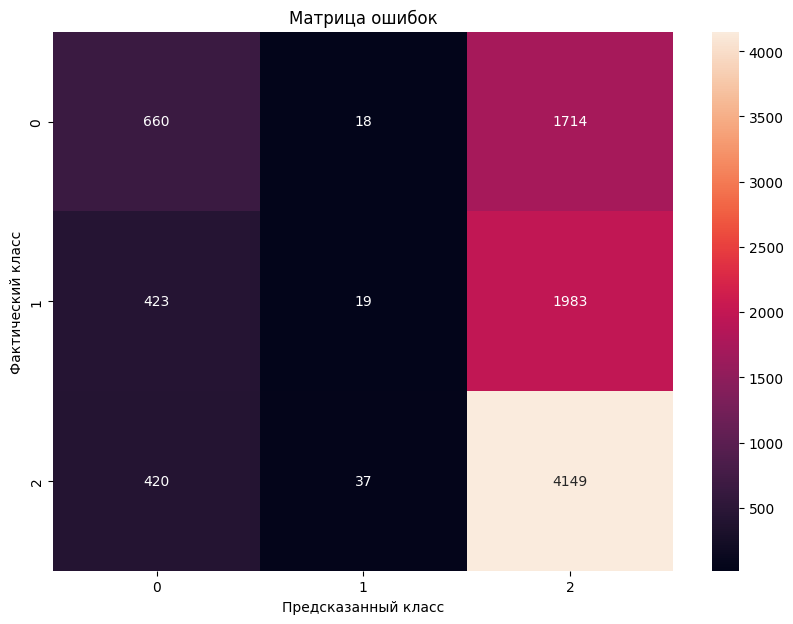

In [ ]:
# Отбор признаков и целевой переменной
BASE = ['H_WIN_PCT_T1', 'A_WIN_PCT_T1','H_DRAW_PCT_T1','A_DRAW_PCT_T1',
        'H_WIN_PCT_T2','A_WIN_PCT_T2','H_DRAW_PCT_T2','A_DRAW_PCT_T2',
        'CUR_WIN_PCT_T1','CUR_DRAW_PCT_T1','CUR_WIN_PCT_T2','CUR_DRAW_PCT_T2',
        'H_GS_AVG_T1','H_GS_AVG_T2','A_GS_AVG_T1','A_GS_AVG_T2','H_GC_AVG_T1','H_GC_AVG_T2',
        'A_GC_AVG_T1','A_GC_AVG_T2','H_GS_STD_T1','H_GS_STD_T2','A_GS_STD_T1','A_GS_STD_T2',
        'H_GC_STD_T1','H_GC_STD_T2','A_GC_STD_T1','A_GC_STD_T2','CUR_GS_AVG_T1','CUR_GS_AVG_T2',
        'CUR_GC_AVG_T1','CUR_GC_AVG_T2','CUR_GS_STD_T1','CUR_GS_STD_T2','CUR_GC_STD_T1','CUR_GC_STD_T2','REST_T1','REST_T2']

teach_model(BASE, 'BASE')

## Base + ks

RPS: 0.1985088941691811, Acc: 0.5279634935795394 for BASE+KS


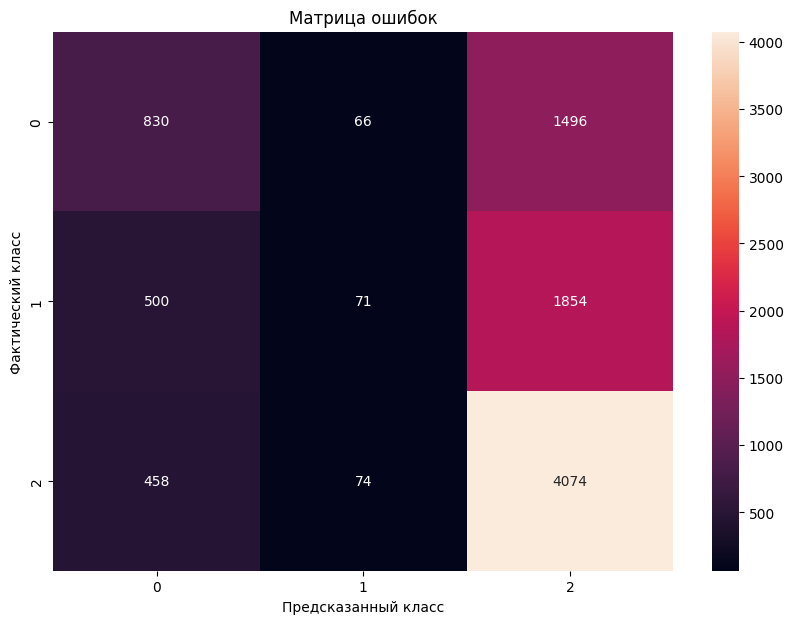

In [ ]:
KS = ['KICKSCORE_MS_T1','KICKSCORE_STD_T1','KICKSCORE_MS_T2','KICKSCORE_STD_T2']

teach_model(BASE + KS, 'BASE+KS')

## Base + ts

RPS: 0.2047453638846481, Acc: 0.5165021755279635 for BASE+TS


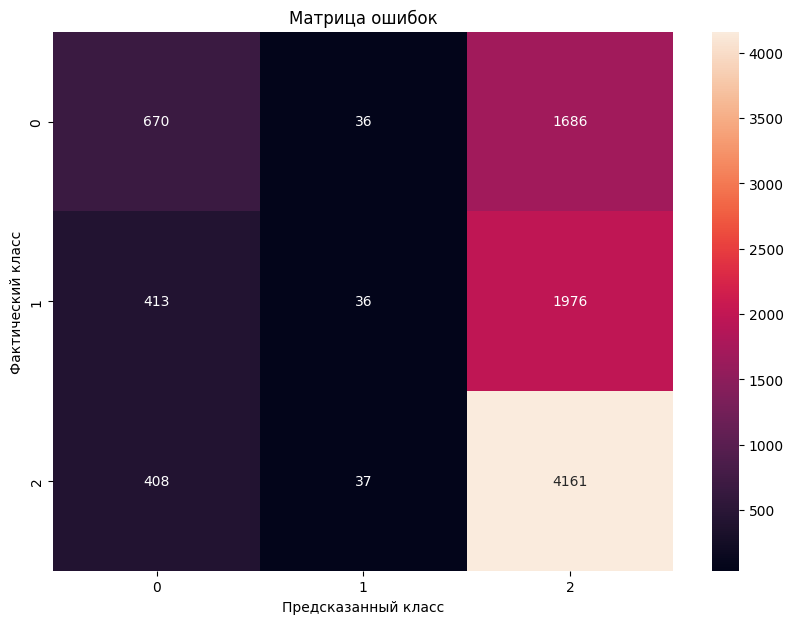

In [ ]:
TS = ['TRUESKILL_MS_T1','TRUESKILL_STD_T1','TRUESKILL_MS_T2','TRUESKILL_STD_T2']

teach_model(BASE + TS, 'BASE+TS')

## Base + elo

RPS: 0.20501371350116268, Acc: 0.5137429693303619 for BASE+ELO


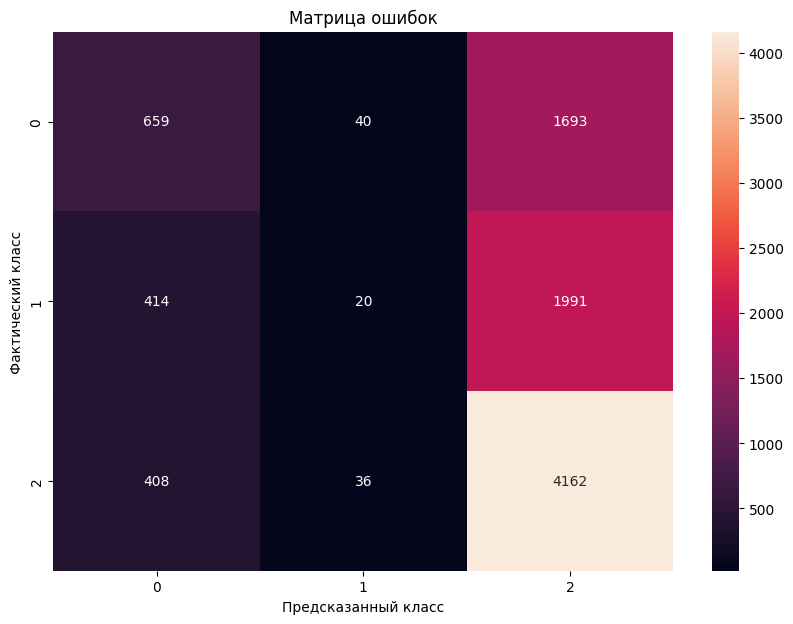

In [ ]:
ELO = ['ELO_T1','ELO_T2']

teach_model(BASE + ELO, 'BASE+ELO')

## Base + ks + ts

RPS: 0.19870106831620488, Acc: 0.5271145070572004 for BASE+KS+TS


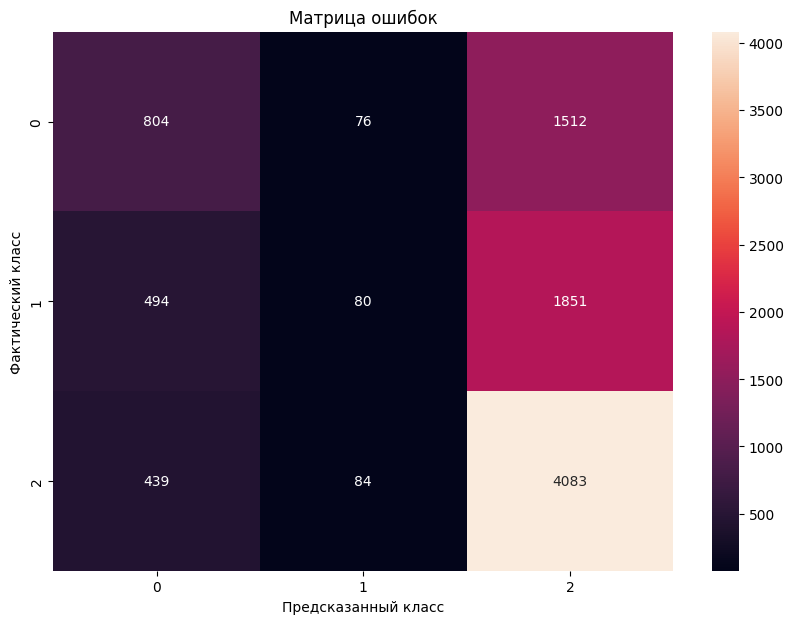

In [ ]:
teach_model(BASE + KS + TS, 'BASE+KS+TS')

## Base + ks + elo

RPS: 0.19893694634526685, Acc: 0.5271145070572004 for BASE+KS+ELO


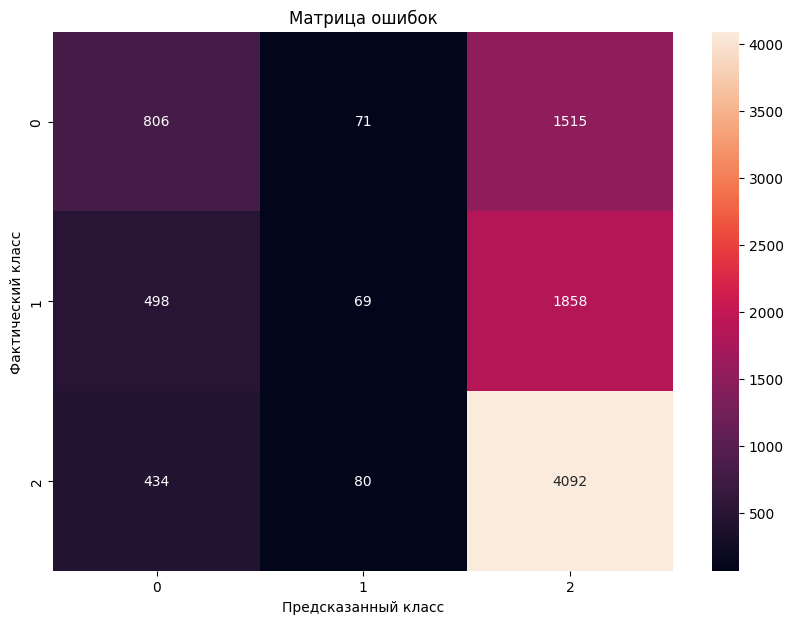

In [ ]:
teach_model(BASE + KS + ELO, 'BASE+KS+ELO')

## Base + ts + elo

RPS: 0.204917009361749, Acc: 0.5150164491138703 for BASE+TS+ELO


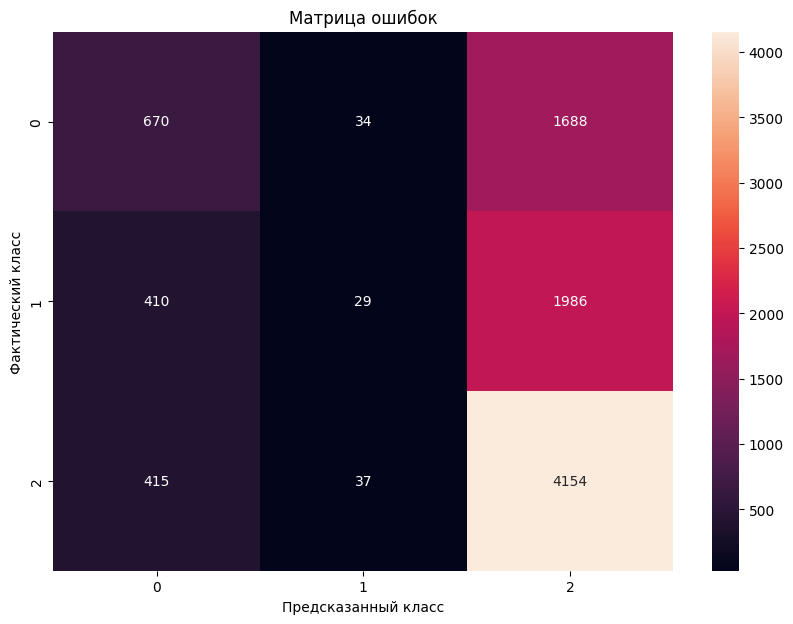

In [ ]:
teach_model(BASE + TS + ELO, 'BASE+TS+ELO')

## Base + ks + ts + elo

RPS: 0.19852581398673108, Acc: 0.5262655205348615 for BASE+KS+TS+ELO


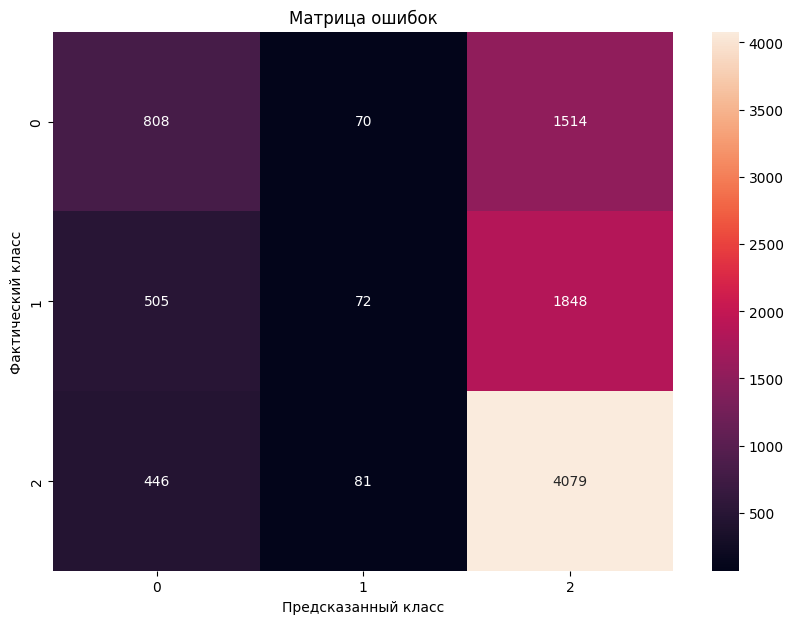

In [ ]:
teach_model(BASE + KS + TS + ELO, 'BASE+KS+TS+ELO')

# Different models

## Model with timestamps

In [ ]:
def teach_model_timestamps(columns, name):
  X = df[columns + ['t']]
  y = df['outcome']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # Создание объектов DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Параметры модели
  params = {
      'max_depth': 4,
      'subsample': 0.8,
      'min_child_weight': 5,
      'colsample_bytree': 0.25,
      'eta': 0.1,
      'objective': 'multi:softprob',
      'num_class': 3
  }

  # Обучение модели
  bst = xgb.train(params, dtrain, num_boost_round=100)

  # Предсказание результатов на тестовой выборке
  preds = bst.predict(dtest)
  predictions = preds.argmax(axis=1)

  # Вычисление точности
  accuracy = accuracy_score(y_test, predictions)

  # Преобразование истинных меток y_test в формат one-hot для вычисления RPS
  y_test_array = y_test.to_numpy() # Предполагаем, что y_test - это pandas Series
  y_true_one_hot_xgb = np.zeros((y_test_array.size, 3))
  y_true_one_hot_xgb[np.arange(y_test_array.size), y_test_array] = 1

  rps_score_xgb = rps(preds, y_true_one_hot_xgb)
  print(f"RPS: {rps_score_xgb}, Acc: {accuracy} for {name}")

  # Получение матрицы ошибок
  conf_matrix = confusion_matrix(y_test, predictions)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                    columns = [i for i in "012"])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='d')
  plt.ylabel('Фактический класс')
  plt.xlabel('Предсказанный класс')
  plt.title('Матрица ошибок')


### Base

RPS: 0.20447423086652042, Acc: 0.5146980791679933 for BASE


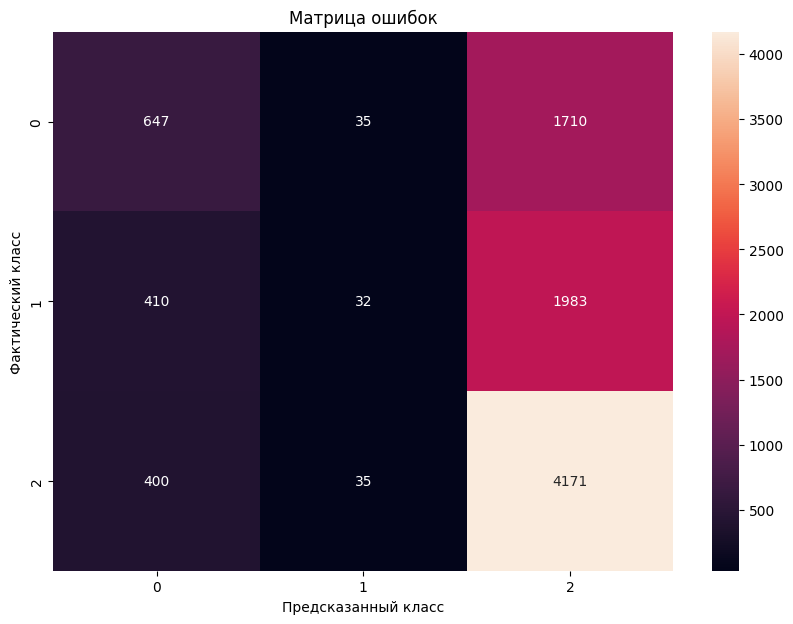

In [ ]:
# Отбор признаков и целевой переменной
BASE = ['H_WIN_PCT_T1', 'A_WIN_PCT_T1','H_DRAW_PCT_T1','A_DRAW_PCT_T1',
        'H_WIN_PCT_T2','A_WIN_PCT_T2','H_DRAW_PCT_T2','A_DRAW_PCT_T2',
        'CUR_WIN_PCT_T1','CUR_DRAW_PCT_T1','CUR_WIN_PCT_T2','CUR_DRAW_PCT_T2',
        'H_GS_AVG_T1','H_GS_AVG_T2','A_GS_AVG_T1','A_GS_AVG_T2','H_GC_AVG_T1','H_GC_AVG_T2',
        'A_GC_AVG_T1','A_GC_AVG_T2','H_GS_STD_T1','H_GS_STD_T2','A_GS_STD_T1','A_GS_STD_T2',
        'H_GC_STD_T1','H_GC_STD_T2','A_GC_STD_T1','A_GC_STD_T2','CUR_GS_AVG_T1','CUR_GS_AVG_T2',
        'CUR_GC_AVG_T1','CUR_GC_AVG_T2','CUR_GS_STD_T1','CUR_GS_STD_T2','CUR_GC_STD_T1','CUR_GC_STD_T2','REST_T1','REST_T2']

teach_model_timestamps(BASE, 'BASE')

### Base + ks

RPS: 0.1986722650613189, Acc: 0.5255226573278149 for BASE+KS


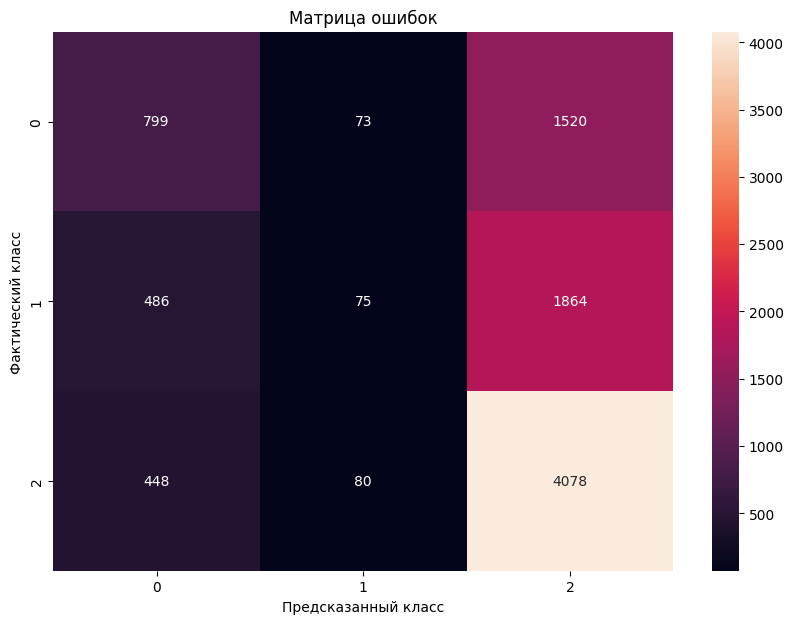

In [ ]:
KS = ['KICKSCORE_MS_T1','KICKSCORE_STD_T1','KICKSCORE_MS_T2','KICKSCORE_STD_T2']

teach_model_timestamps(BASE + KS, 'BASE+KS')

### Base + ts

RPS: 0.20450198537325545, Acc: 0.5153348190597474 for BASE+TS


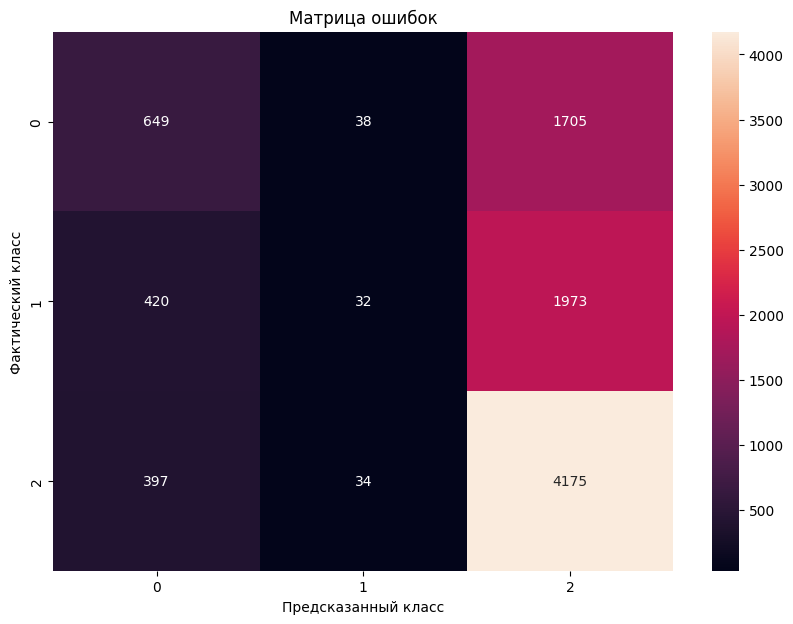

In [ ]:
TS = ['TRUESKILL_MS_T1','TRUESKILL_STD_T1','TRUESKILL_MS_T2','TRUESKILL_STD_T2']

teach_model_timestamps(BASE + TS, 'BASE+TS')

### Base + elo

RPS: 0.20487856626627593, Acc: 0.5163960522126712 for BASE+ELO


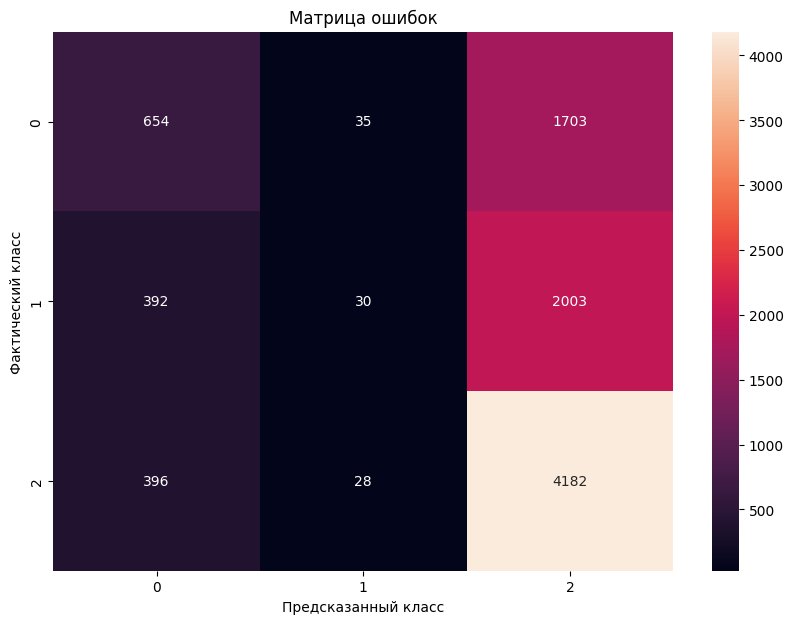

In [ ]:
ELO = ['ELO_T1','ELO_T2']

teach_model_timestamps(BASE + ELO, 'BASE+ELO')

### Base + ks + ts

RPS: 0.19850229227599128, Acc: 0.5297675899395097 for BASE+KS+TS


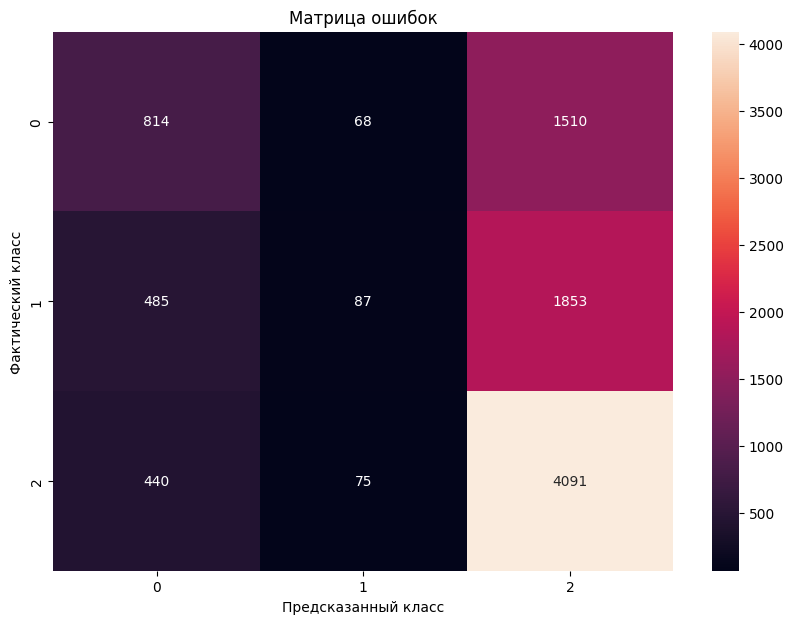

In [ ]:
teach_model_timestamps(BASE + KS + TS, 'BASE+KS+TS')

### Base + ks + elo

RPS: 0.19872453758543984, Acc: 0.5261593972195692 for BASE+KS+ELO


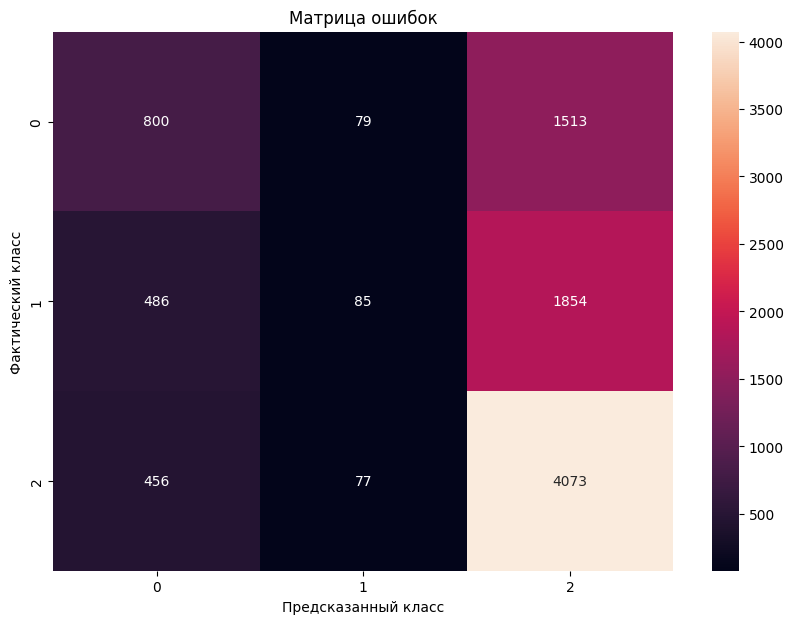

In [ ]:
teach_model_timestamps(BASE + KS + ELO, 'BASE+KS+ELO')

### Base + ts + elo

RPS: 0.20457145907978574, Acc: 0.5144858325374084 for BASE+TS+ELO


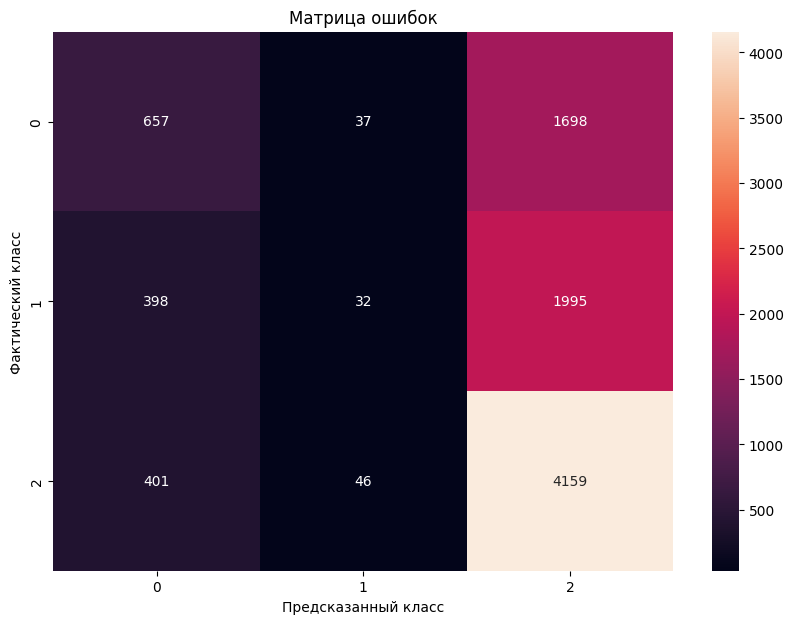

In [ ]:
teach_model_timestamps(BASE + TS + ELO, 'BASE+TS+ELO')

### Base + ks + ts + elo

RPS: 0.19856651526251365, Acc: 0.524673670805476 for BASE+KS+TS+ELO


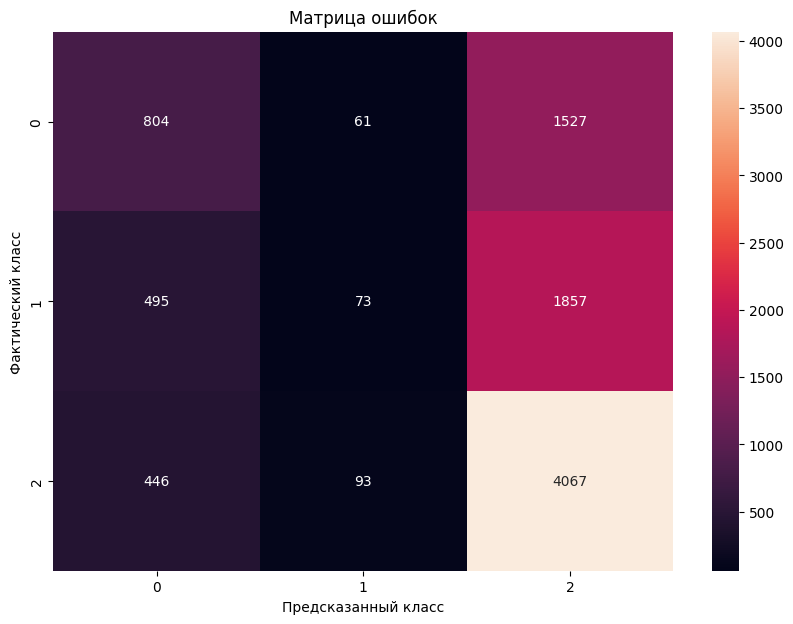

In [ ]:
teach_model_timestamps(BASE + KS + TS + ELO, 'BASE+KS+TS+ELO')

## Model with no random (without timestamps)

In [ ]:
def teach_model_norandom(columns, name):
  X = df[columns + ['season_num']]
  y = df['outcome']

  X_train = X[X['season_num'] <= 70] # сезон 2019/2020 попадет в train
  X_test = X[X['season_num'] > 70]

  X_train = X_train.drop(['season_num'], axis = 1)
  X_test = X_test.drop(['season_num'], axis = 1)

  y_train = y[y.index.isin(X_train.index)]
  y_test = y[y.index.isin(X_test.index)]

  # Создание объектов DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Параметры модели
  params = {
      'max_depth': 4,
      'subsample': 0.8,
      'min_child_weight': 5,
      'colsample_bytree': 0.25,
      'eta': 0.1,
      'objective': 'multi:softprob',
      'num_class': 3
  }

  # Обучение модели
  bst = xgb.train(params, dtrain, num_boost_round=100)

  # Предсказание результатов на тестовой выборке
  preds = bst.predict(dtest)
  predictions = preds.argmax(axis=1)

  # Вычисление точности
  accuracy = accuracy_score(y_test, predictions)

  # Преобразование истинных меток y_test в формат one-hot для вычисления RPS
  y_test_array = y_test.to_numpy() # Предполагаем, что y_test - это pandas Series
  y_true_one_hot_xgb = np.zeros((y_test_array.size, 3))
  y_true_one_hot_xgb[np.arange(y_test_array.size), y_test_array] = 1

  rps_score_xgb = rps(preds, y_true_one_hot_xgb)
  print(f"RPS: {rps_score_xgb}, Acc: {accuracy} for {name}")

  # Получение матрицы ошибок
  conf_matrix = confusion_matrix(y_test, predictions)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                    columns = [i for i in "012"])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='d')
  plt.ylabel('Фактический класс')
  plt.xlabel('Предсказанный класс')
  plt.title('Матрица ошибок')


### Base

RPS: 0.20906852063620732, Acc: 0.5188343994314144 for BASE


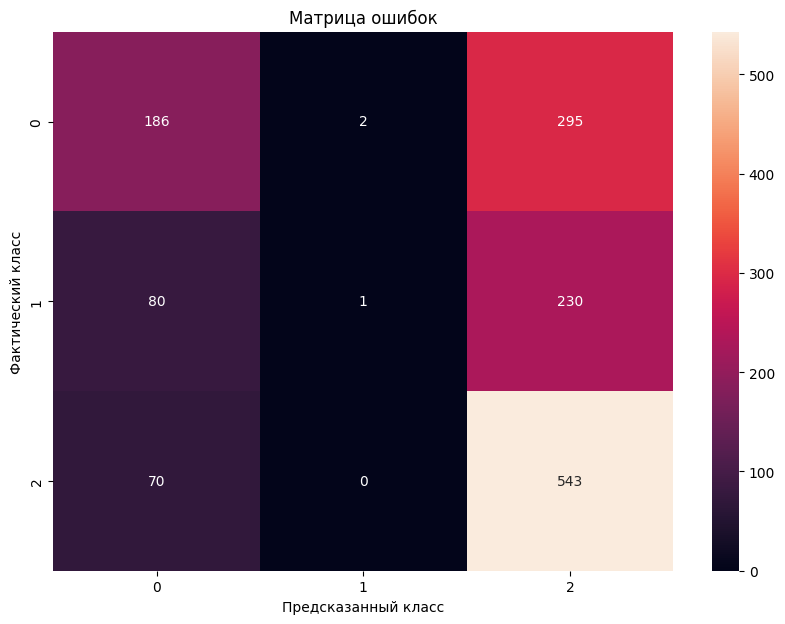

In [ ]:
# Отбор признаков и целевой переменной
BASE = ['H_WIN_PCT_T1', 'A_WIN_PCT_T1','H_DRAW_PCT_T1','A_DRAW_PCT_T1',
        'H_WIN_PCT_T2','A_WIN_PCT_T2','H_DRAW_PCT_T2','A_DRAW_PCT_T2',
        'CUR_WIN_PCT_T1','CUR_DRAW_PCT_T1','CUR_WIN_PCT_T2','CUR_DRAW_PCT_T2',
        'H_GS_AVG_T1','H_GS_AVG_T2','A_GS_AVG_T1','A_GS_AVG_T2','H_GC_AVG_T1','H_GC_AVG_T2',
        'A_GC_AVG_T1','A_GC_AVG_T2','H_GS_STD_T1','H_GS_STD_T2','A_GS_STD_T1','A_GS_STD_T2',
        'H_GC_STD_T1','H_GC_STD_T2','A_GC_STD_T1','A_GC_STD_T2','CUR_GS_AVG_T1','CUR_GS_AVG_T2',
        'CUR_GC_AVG_T1','CUR_GC_AVG_T2','CUR_GS_STD_T1','CUR_GS_STD_T2','CUR_GC_STD_T1','CUR_GC_STD_T2','REST_T1','REST_T2']

teach_model_norandom(BASE, 'BASE')

### Base + ks

RPS: 0.19880822264071601, Acc: 0.5572139303482587 for BASE+KS


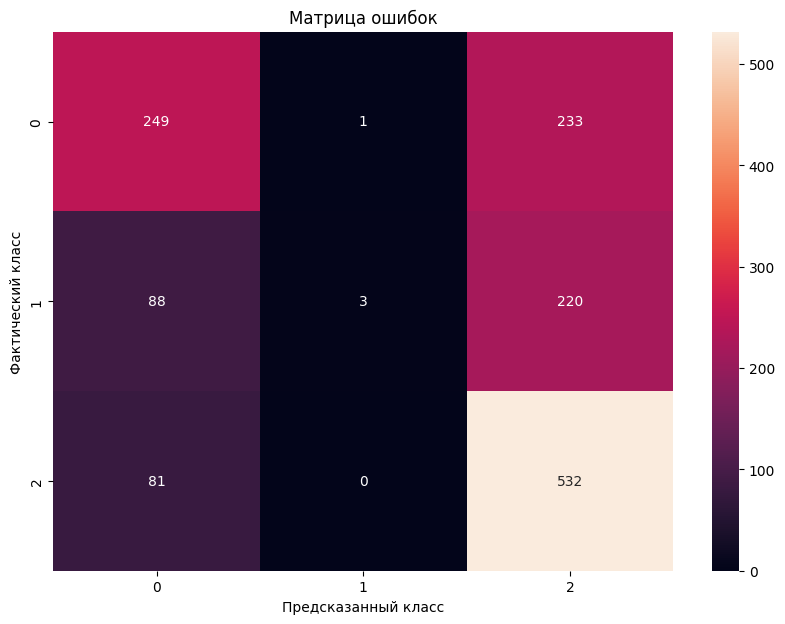

In [ ]:
KS = ['KICKSCORE_MS_T1','KICKSCORE_STD_T1','KICKSCORE_MS_T2','KICKSCORE_STD_T2']

teach_model_norandom(BASE + KS, 'BASE+KS')

### Base + ts

RPS: 0.20843836564267487, Acc: 0.5223880597014925 for BASE+TS


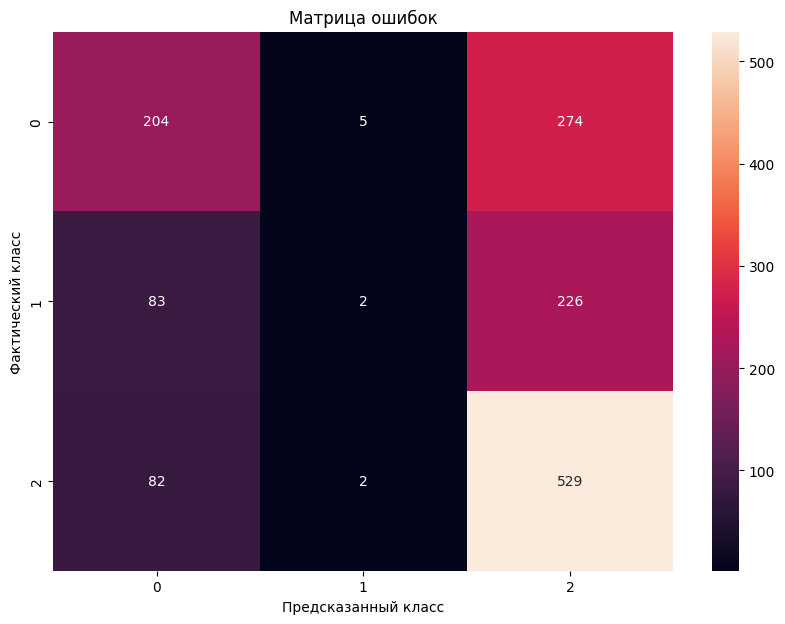

In [ ]:
TS = ['TRUESKILL_MS_T1','TRUESKILL_STD_T1','TRUESKILL_MS_T2','TRUESKILL_STD_T2']

teach_model_norandom(BASE + TS, 'BASE+TS')

### Base + elo

RPS: 0.20792690541394365, Acc: 0.5138592750533049 for BASE+ELO


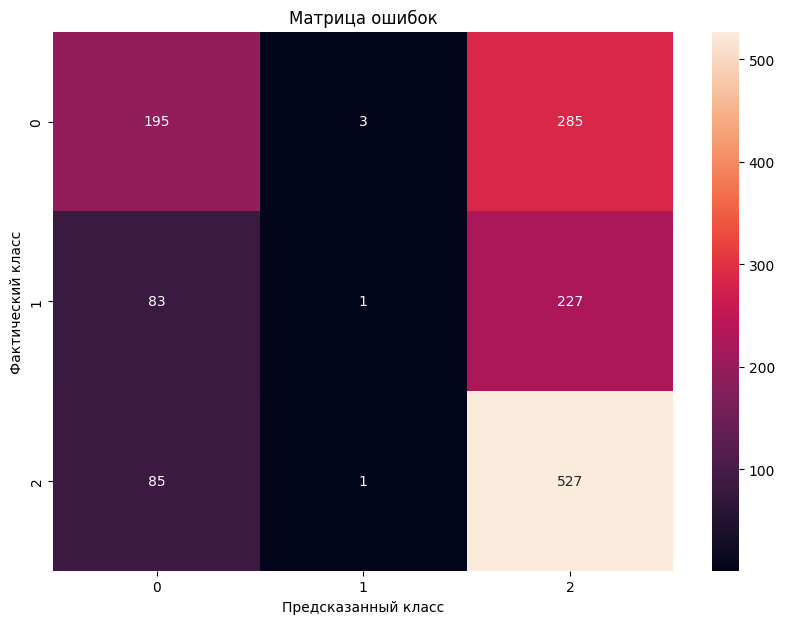

In [ ]:
ELO = ['ELO_T1','ELO_T2']

teach_model_norandom(BASE + ELO, 'BASE+ELO')

### Base + ks + ts

RPS: 0.19945972188270752, Acc: 0.5543710021321961 for BASE+KS+TS


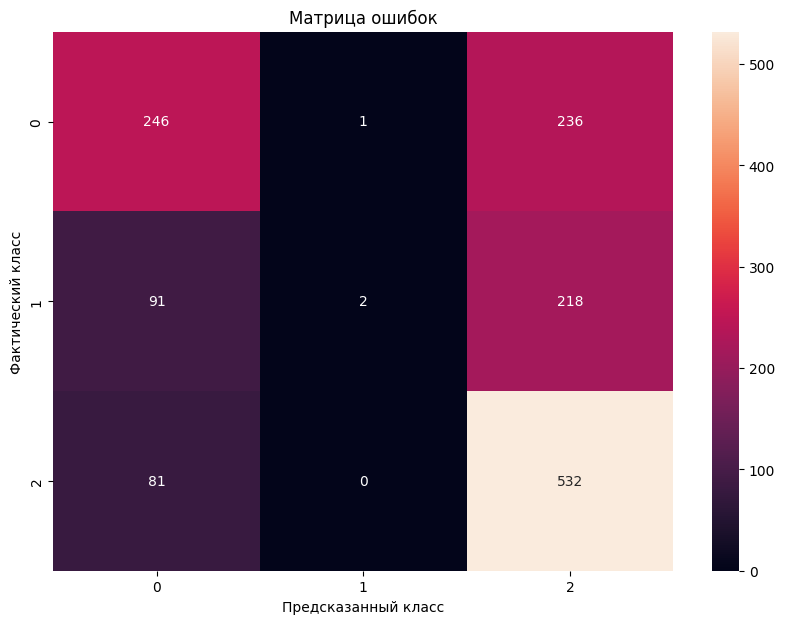

In [ ]:
teach_model_norandom(BASE + KS + TS, 'BASE+KS+TS')

### Base + ks + elo

RPS: 0.19957668752738186, Acc: 0.5501066098081023 for BASE+KS+ELO


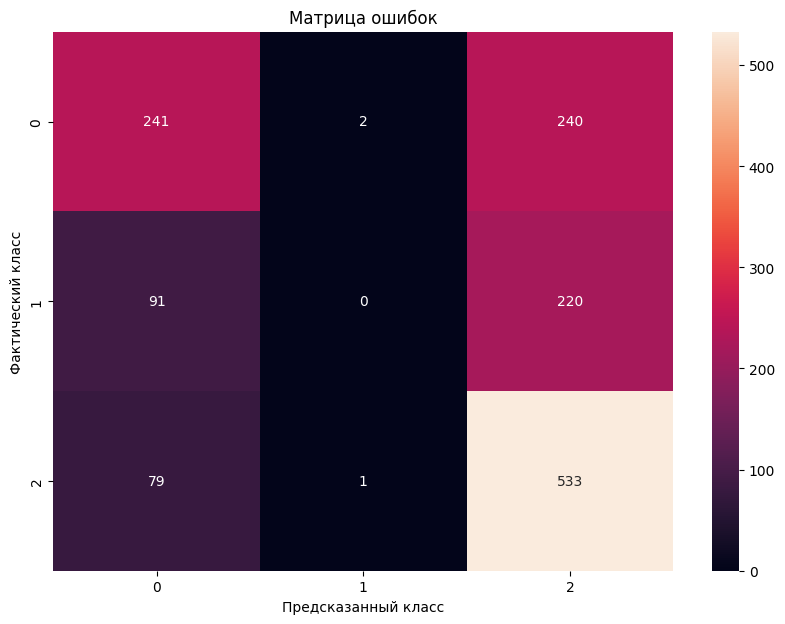

In [ ]:
teach_model_norandom(BASE + KS + ELO, 'BASE+KS+ELO')

### Base + ts + elo

RPS: 0.20829304232134932, Acc: 0.5266524520255863 for BASE+TS+ELO


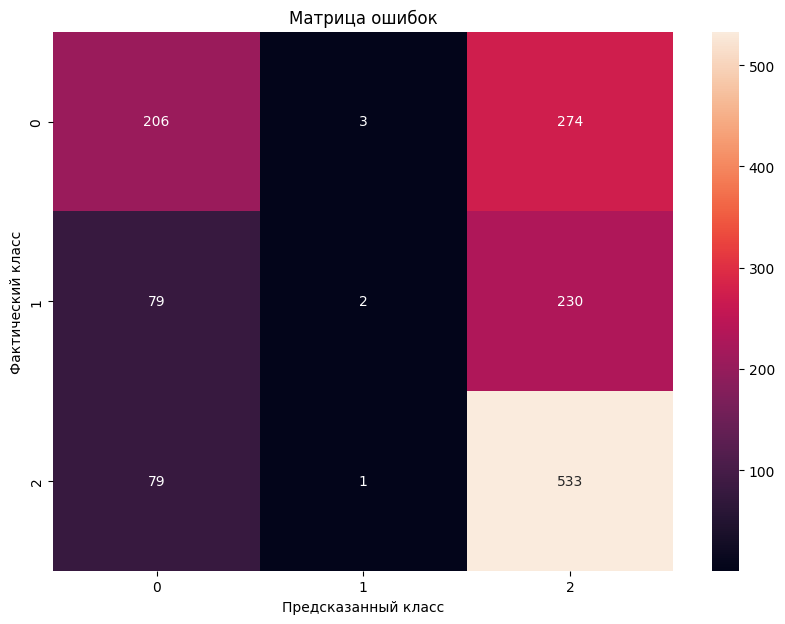

In [ ]:
teach_model_norandom(BASE + TS + ELO, 'BASE+TS+ELO')

### Base + ks + ts + elo

RPS: 0.1996345760904303, Acc: 0.5465529495380241 for BASE+KS+TS+ELO


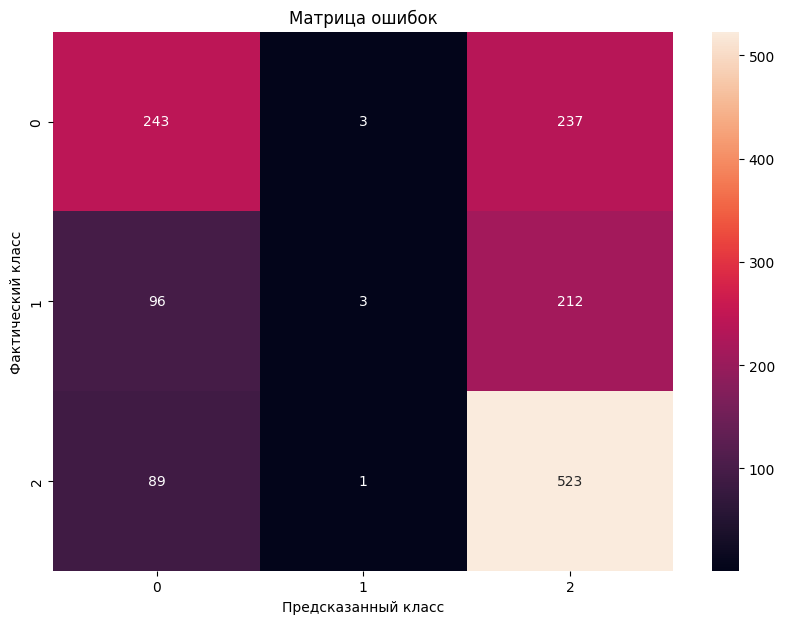

In [ ]:
teach_model_norandom(BASE + KS + TS + ELO, 'BASE+KS+TS+ELO')

## Model with timestamps + no random

In [ ]:
def teach_model_timestamps_norandom(columns, name):
  X = df[columns + ['season_num', 't']]
  y = df['outcome']

  X_train = X[X['season_num'] <= 70] # сезон 2019/2020 попадет в train
  X_test = X[X['season_num'] > 70]

  X_train = X_train.drop(['season_num'], axis = 1)
  X_test = X_test.drop(['season_num'], axis = 1)

  y_train = y[y.index.isin(X_train.index)]
  y_test = y[y.index.isin(X_test.index)]

  # Создание объектов DMatrix
  dtrain = xgb.DMatrix(X_train, label=y_train)
  dtest = xgb.DMatrix(X_test, label=y_test)

  # Параметры модели
  params = {
      'max_depth': 4,
      'subsample': 0.8,
      'min_child_weight': 5,
      'colsample_bytree': 0.25,
      'eta': 0.1,
      'objective': 'multi:softprob',
      'num_class': 3
  }

  # Обучение модели
  bst = xgb.train(params, dtrain, num_boost_round=100)

  # Предсказание результатов на тестовой выборке
  preds = bst.predict(dtest)
  predictions = preds.argmax(axis=1)

  # Вычисление точности
  accuracy = accuracy_score(y_test, predictions)

  # Преобразование истинных меток y_test в формат one-hot для вычисления RPS
  y_test_array = y_test.to_numpy() # Предполагаем, что y_test - это pandas Series
  y_true_one_hot_xgb = np.zeros((y_test_array.size, 3))
  y_true_one_hot_xgb[np.arange(y_test_array.size), y_test_array] = 1

  rps_score_xgb = rps(preds, y_true_one_hot_xgb)
  print(f"RPS: {rps_score_xgb}, Acc: {accuracy} for {name}")

  # Получение матрицы ошибок
  conf_matrix = confusion_matrix(y_test, predictions)
  df_cm = pd.DataFrame(conf_matrix, index = [i for i in "012"],
                    columns = [i for i in "012"])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True, fmt='d')
  plt.ylabel('Фактический класс')
  plt.xlabel('Предсказанный класс')
  plt.title('Матрица ошибок')


### Base

RPS: 0.20796073610592947, Acc: 0.5294953802416489 for BASE


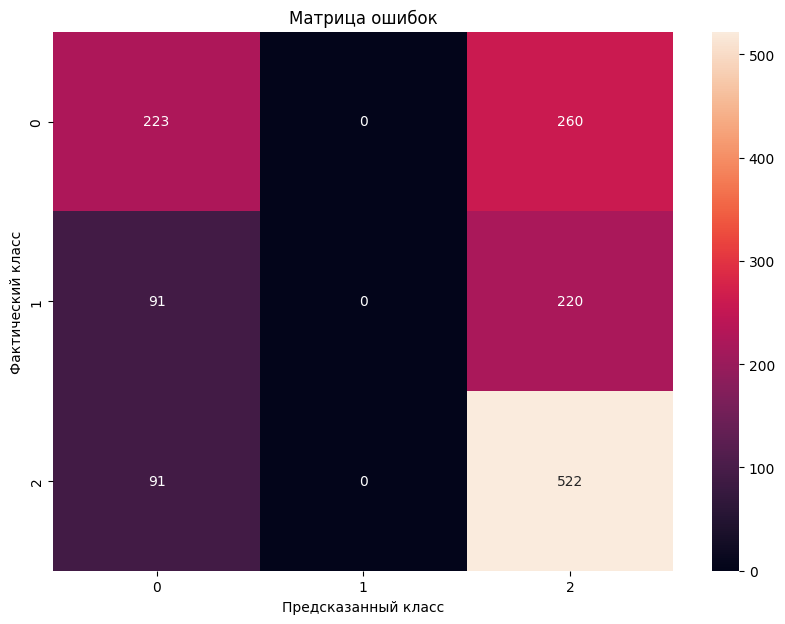

In [ ]:
# Отбор признаков и целевой переменной
BASE = ['H_WIN_PCT_T1', 'A_WIN_PCT_T1','H_DRAW_PCT_T1','A_DRAW_PCT_T1',
        'H_WIN_PCT_T2','A_WIN_PCT_T2','H_DRAW_PCT_T2','A_DRAW_PCT_T2',
        'CUR_WIN_PCT_T1','CUR_DRAW_PCT_T1','CUR_WIN_PCT_T2','CUR_DRAW_PCT_T2',
        'H_GS_AVG_T1','H_GS_AVG_T2','A_GS_AVG_T1','A_GS_AVG_T2','H_GC_AVG_T1','H_GC_AVG_T2',
        'A_GC_AVG_T1','A_GC_AVG_T2','H_GS_STD_T1','H_GS_STD_T2','A_GS_STD_T1','A_GS_STD_T2',
        'H_GC_STD_T1','H_GC_STD_T2','A_GC_STD_T1','A_GC_STD_T2','CUR_GS_AVG_T1','CUR_GS_AVG_T2',
        'CUR_GC_AVG_T1','CUR_GC_AVG_T2','CUR_GS_STD_T1','CUR_GS_STD_T2','CUR_GC_STD_T1','CUR_GC_STD_T2','REST_T1','REST_T2']

teach_model_timestamps_norandom(BASE, 'BASE')

### Base + ks

RPS: 0.19917571627046482, Acc: 0.5536602700781805 for BASE+KS


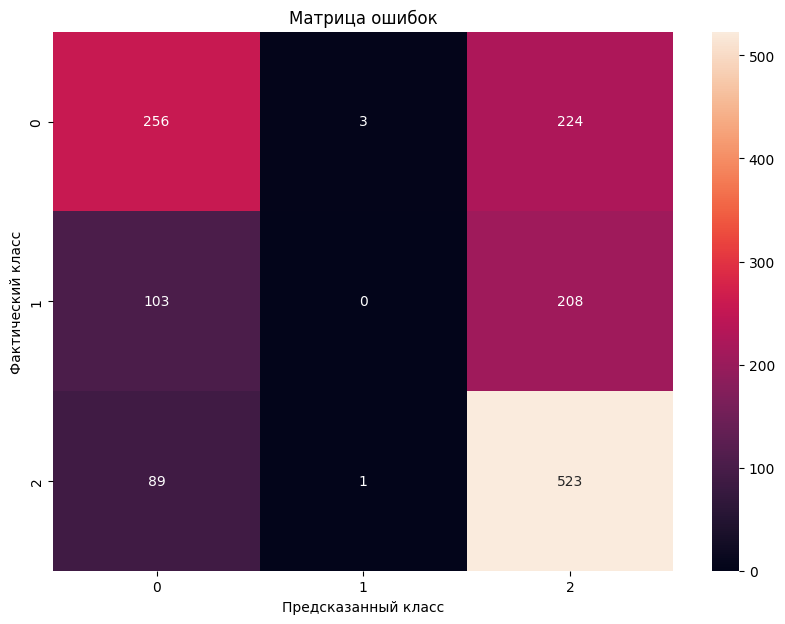

In [ ]:
KS = ['KICKSCORE_MS_T1','KICKSCORE_STD_T1','KICKSCORE_MS_T2','KICKSCORE_STD_T2']

teach_model_timestamps_norandom(BASE + KS, 'BASE+KS')

### Base + ts

RPS: 0.2070522314878077, Acc: 0.5323383084577115 for BASE+TS


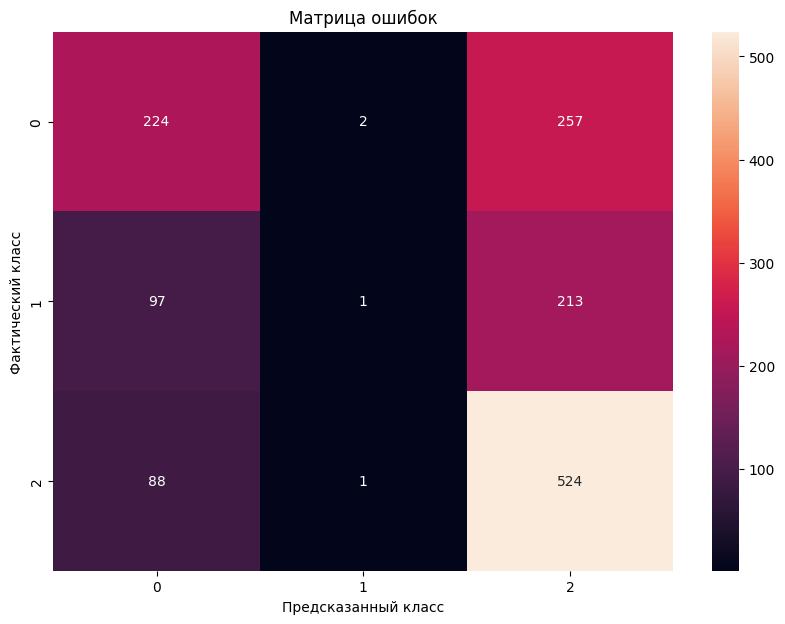

In [ ]:
TS = ['TRUESKILL_MS_T1','TRUESKILL_STD_T1','TRUESKILL_MS_T2','TRUESKILL_STD_T2']

teach_model_timestamps_norandom(BASE + TS, 'BASE+TS')

### Base + elo

RPS: 0.20720032968551363, Acc: 0.5280739161336176 for BASE+ELO


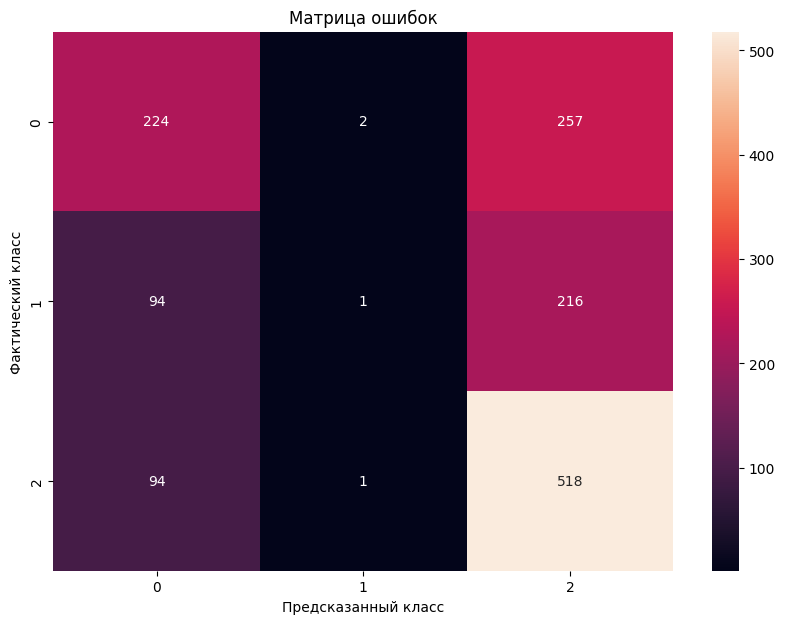

In [ ]:
ELO = ['ELO_T1','ELO_T2']

teach_model_timestamps_norandom(BASE + ELO, 'BASE+ELO')

### Base + ks + ts

RPS: 0.19903706198368684, Acc: 0.5557924662402275 for BASE+KS+TS


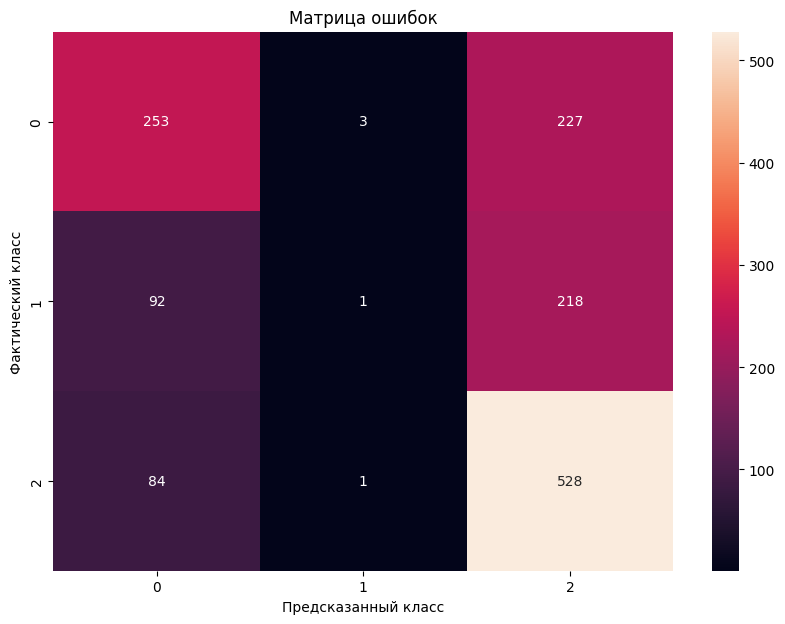

In [ ]:
teach_model_timestamps_norandom(BASE + KS + TS, 'BASE+KS+TS')

### Base + ks + elo

RPS: 0.1979343109713377, Acc: 0.5550817341862118 for BASE+KS+ELO


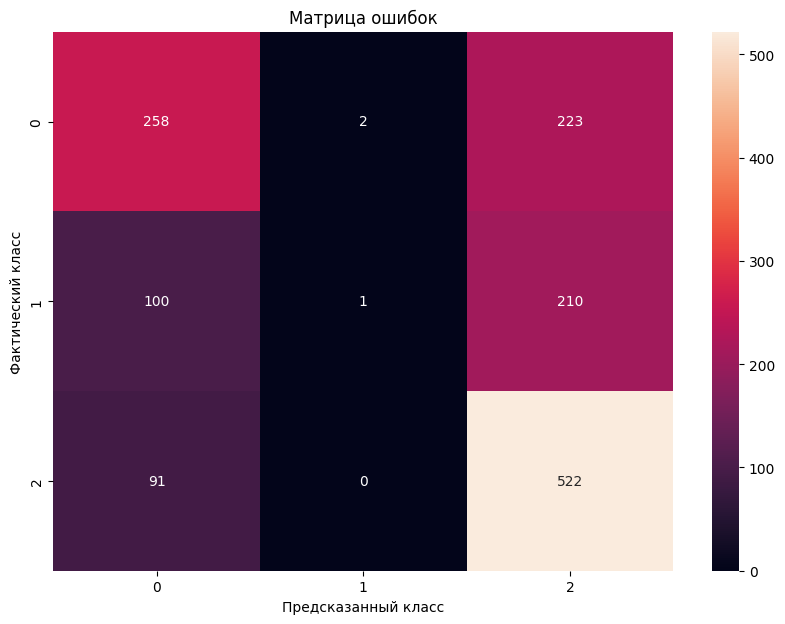

In [ ]:
teach_model_timestamps_norandom(BASE + KS + ELO, 'BASE+KS+ELO')

### Base + ts + elo

RPS: 0.20663155529791874, Acc: 0.5266524520255863 for BASE+TS+ELO


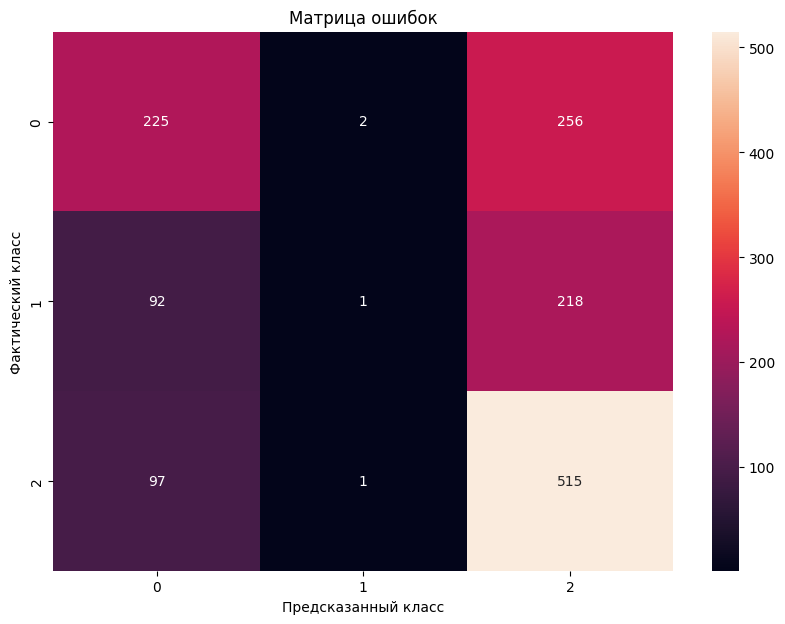

In [ ]:
teach_model_timestamps_norandom(BASE + TS + ELO, 'BASE+TS+ELO')

### Base + ks + ts + elo

RPS: 0.19856503515435622, Acc: 0.5515280739161336 for BASE+KS+TS+ELO


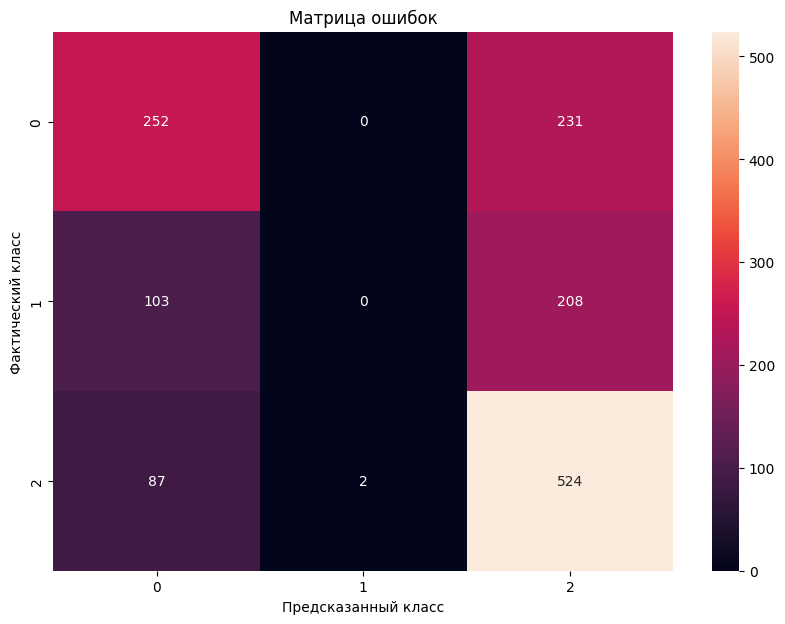

In [ ]:
teach_model_timestamps_norandom(BASE + KS + TS + ELO, 'BASE+KS+TS+ELO')

# Results

Сводная таблица по ссылке: https://fuschia-collarbone-eff.notion.site/2-5-c5e6d6bc4424481fb71421ec16ae88c9?pvs=4